# ECON-GA-4005 Spring 2022 Midterm

Welcome to the Sprint 2022 midterm exam.

Please begin by adding your name and NID below

Name: Jingyi Fan

NID: N15191508


## Background/Instructions

The midterm is to complete a slightly modified version of the exercises in the QuantEcon datascience classification lecture (which can be found here [here](https://datascience.quantecon.org/applications/classification.html))

There are a total of 8 questions that need to be completed and plenty of learning/reading material along the way.

Please make sure to attempt/complete all 8 exercises to the best of your ability. Note that some questions have multiple parts. Read the question carefully and respond to each part.

Next to each exercise will be a point total for that question. There are a total of 150 points possible in this exam.

Once you have completed all questions, please upload your completed notebook to Brightspace. **Do not** change the name of the notebook. It should remain `classification.ipynb`

You are permitted to use any existing online resource as you work on the exam. Google is your friend. You are not permitted to post a question to a forum, message group, or any other form of online or in person communication to get help on the exam.

You are to work alone.

There is no autograding for this assignemnt. All responses will be graded by one of the professors.

If you have quesitons, you can email one of the professors or post a question on Brightspace (if your question is potentially helpful to other students, we may ask that an emailed question be reposted on Brightspace). We will only answer *clarifying* questions if something is unclear.

# Classification

**Authors**

> Chase Coleman, Spencer Lyon, Jesse Perla

**Co-authors**

> - [Quentin Batista *University of Tokyo*](https://github.com/QBatista)  
> - [Thomas Sargent *NYU*](http://www.tomsargent.com/)  
> - [Paul Schrimpf *UBC*](https://economics.ubc.ca/faculty-and-staff/paul-schrimpf/)  
> - [Natasha Watkins *UCLA*](https://github.com/natashawatkins)  



**Prerequisites**

- [Regression](https://datascience.quantecon.org/regression.html)  


**Outcomes**

- Understand what problems classification solves  
- Evaluate classification models using a variety of metrics  

In [1]:
# Uncomment following line to install on colab
# ! pip install fiona geopandas xgboost gensim folium pyLDAvis descartes

## Introduction to Classification

We now move from regression to the second main branch of machine learning:
classification.

Recall that the regression problem mapped a set of
feature variables to a continuous target.

Classification is similar to regression, but instead of predicting a continuous
target, classification algorithms attempt to apply one (or more) of a discrete
number of labels or classes to each observation.

Another perspective is that for regression, the targets are usually
continuous-valued, while in classification, the targets are categorical.

Common examples of classification problems are

- Labeling emails as spam or not spam  
- Person identification in a photo  
- Speech recognition  
- Whether or not a country is or will be in a recession  


Classification can also be applied in settings where the target isn’t naturally
categorical.

For example, suppose we want to predict whether the unemployment rate for a state
will be low ($ <3\% $), medium ($ \in [3\%, 5\%] $), or high ($ >5\% $)
but don’t care about the actual number.

Most economic problems are posed in continuous terms, so it may take some creativity
to determine the optimal way to categorize a target variable so
classification algorithms can be applied.

As many problems can be posed either as classification or regression, many
machine learning algorithms have variants that perform regression or
classification tasks.

Throughout this lecture, we will revisit some of the algorithms from the
[regression](https://datascience.quantecon.org/regression.html) lecture and discuss how they can be applied in
classification settings.

As we have already seen relatives of these algorithms, this lecture will be
lighter on exposition and then build up to an application.

In [2]:
import datetime
import numpy as np
import pandas as pd
import pandas_datareader.data as web

from sklearn import (
    linear_model, metrics, pipeline, preprocessing, model_selection
)

import matplotlib.pyplot as plt
%matplotlib inline

## Warmup Example: Logistic Regression

We have actually already encountered a classification algorithm.

In the [recidivism](https://datascience.quantecon.org/recidivism.html) example, we attempted to predict whether
or not an individual would commit another crime by using a combination of the
assigned COMPAS score and the individual’s gender or race.

In that example, we used a *logistic regression* model, which is a close
relative of the linear regression model from the [regression](https://datascience.quantecon.org/regression.html) section.

The logistic regression model for predicting the likelihood of recidivism using
the `COMPAS` score as the single feature is written

$$
p(\text{recid}) = L(\beta_0 + \beta_1 \text{COMPAS} + \epsilon)
$$

where $ L $ is the *logistic function*: $ L(x) = \frac{1}{1 + e^{-x}} $.

To get some intuition for this function, let’s plot it below.

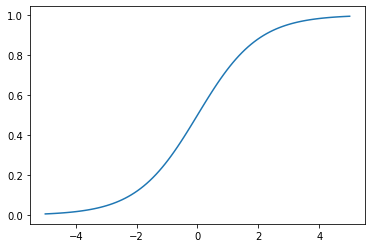

In [3]:
x = np.linspace(-5, 5, 100)
y = 1/(1+np.exp(-x))
plt.plot(x, y)

Notice that for all values of $ x $, the value of the logistic function is
always between 0 and 1.

This is perfect for binary classification problems that need to
output the probability of one of the two labels.

Let’s load up the recidivism data and fit the logistic regression model.

In [4]:
data_url = "https://raw.githubusercontent.com/propublica/compas-analysis"
data_url += "/master/compas-scores-two-years.csv"

df = pd.read_csv(data_url)
df.head()

X = df[["decile_score"]]
y = df["two_year_recid"]
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

logistic_model = linear_model.LogisticRegression(solver="lbfgs")
logistic_model.fit(X_train, y_train)

beta_0 = logistic_model.intercept_[0]
beta_1 = logistic_model.coef_[0][0]

print(f"Fit model: p(recid) = L({beta_0:.4f} + {beta_1:.4f} decile_score)")

Fit model: p(recid) = L(-1.3919 + 0.2657 decile_score)


From these coefficients, we see that an increase in the `decile_score` leads
to an increase in the predicted probability of recidivism.

Suppose we choose to classify any model output greater than 0.5 as “at risk of
recidivism”.

Then, the positive coefficient on `decile_score` means that there is some cutoff score above which all individuals will be labeled as high-risk.

### Exercise 1 (10 points)

Determine the level of this cutoff value. That is, compute that value of COMPAS that will
cause the model prediction to be exactly 0.5 

> Hint: Recall that the COMPAS score takes on integer values between 1 and 10, inclusive.

What happens to the cutoff level of the `decile_score` when you change
the classification threshold from 0.5 to 0.7? What about 0.3? Remember this
idea – we’ll come back to it soon.


In [5]:
import math
X_cutoff_1 = (-np.log(1/0.5-1) - beta_0)/beta_1
print(f"A COMPAS value of {X_cutoff_1:.4f} will cause the model prediction to be exactly 0.5. It means for any CAMPS >= %d the individuals can be labeled as high risk of recidivism."% math.ceil(X_cutoff_1))

A COMPAS value of 5.2377 will cause the model prediction to be exactly 0.5. It means for any CAMPS >= 6 the individuals can be labeled as high risk of recidivism.


In [6]:
X_cutoff_2 = (-np.log(1/0.7-1) - beta_0)/beta_1
print(f"A COMPAS value of {X_cutoff_2:.4f} will cause the model prediction to be exactly 0.7. It means for any CAMPS >= %d the individuals can be labeled as high risk of recidivism."% math.ceil(X_cutoff_2))

A COMPAS value of 8.4261 will cause the model prediction to be exactly 0.7. It means for any CAMPS >= 9 the individuals can be labeled as high risk of recidivism.


In [7]:
X_cutoff_3 = (-np.log(1/0.3-1) - beta_0)/beta_1
print(f"A COMPAS value of {X_cutoff_3:.4f} will cause the model prediction to be exactly 0.3. It means for any CAMPS >= %d the individuals can be labeled as high risk of recidivism."% math.ceil(X_cutoff_3))

A COMPAS value of 2.0492 will cause the model prediction to be exactly 0.3. It means for any CAMPS >= 3 the individuals can be labeled as high risk of recidivism.


### Visualization: Decision Boundaries

With just one feature that has a positive coefficient, the model’s predictions
will always have this cutoff structure.

Let’s add a second feature the model: the age of the individual.

In [8]:
X = df[["decile_score", "age"]]
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, test_size=0.25, random_state=42
)

logistic_age_model = linear_model.LogisticRegression(solver="lbfgs")
logistic_age_model.fit(X_train, y_train)

beta_0 = logistic_age_model.intercept_[0]
beta_1, beta_2 = logistic_age_model.coef_[0]

print(f"Fit model: p(recid) = L({beta_0:.4f} + {beta_1:.4f} decile_score + {beta_2:.4f} age)")

Fit model: p(recid) = L(-0.8505 + 0.2470 decile_score + -0.0130 age)


Here, we see that an increase in the `decile_score` still leads to an increase in
the predicted probability of recidivism, while older individuals are slightly
less likely to commit crime again.

We’ll build on an example from the [scikit-learn documentation](https://scikit-learn.org/stable/auto_examples/svm/plot_iris_svc.html) to visualize the predictions of this model.

/Users/clairefan/opt/anaconda3/envs/MLClass/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


<AxesSubplot:xlabel='decile_score', ylabel='age'>

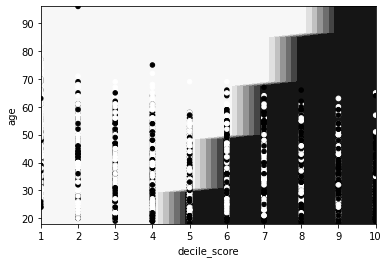

In [9]:
def plot_contours(ax, mod, xx, yy, **params):
    """
    Plot the decision boundaries for a classifier with 2 features x and y.

    Parameters
    ----------
    ax: matplotlib axes object
    mod: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = mod.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

def fit_and_plot_decision_boundary(mod, X, y, **params):
    # fit model
    mod.fit(X, y)

    # generate grids of first two columns of X
    def gen_grid(xseries):
        if xseries.nunique() < 50:
            return sorted(xseries.unique())
        else:
            return np.linspace(xseries.min(), xseries.max(), 50)

    x1, x2 = np.meshgrid(gen_grid(X.iloc[:, 0]), gen_grid(X.iloc[:, 1]))

    # plot contours and scatter
    fig, ax = plt.subplots()
    plot_contours(ax, mod, x1, x2, **params)
    x1_name, x2_name = list(X)[:2]
    X.plot.scatter(x=x1_name, y=x2_name, color=y, ax=ax)
    ax.set_xlabel(x1_name)
    ax.set_ylabel(x2_name)

    return ax

fit_and_plot_decision_boundary(
    linear_model.LogisticRegression(solver="lbfgs"),
    X_train, y_train, cmap=plt.cm.Greys
)

In this plot, we can clearly see the relationships we identified from the
coefficients.

However, we do see that the model is not perfect, as some solid circles are
in the light section and some light circles in the solid section.

This is likely caused by two things:

1. The model inside the logistic function is a linear regression – thus only a
  linear combination of the input features can be used for prediction.  
1. Drawing a straight line (linear) that perfectly separates
  true observations from the false is impossible.  

### Exercise 2 (15 points)

Experiment with different pairs of features to see which ones show the
clearest decision boundaries.

Feed different `X` DataFrames into the `fit_and_plot_decision_boundary` function above.


Try at least three different pairs of features.


/Users/clairefan/opt/anaconda3/envs/MLClass/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Fit model: p(recid) = L(-1.2968 + 0.2643 decile_score + -0.4134 sex)


<AxesSubplot:xlabel='decile_score', ylabel='sex_numeric'>

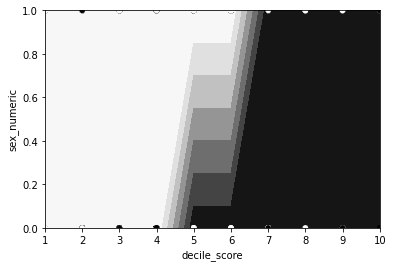

In [10]:
# Pair 1
df[["sex_numeric"]] = df[["sex"]]
df["sex_numeric"].replace(["Male", "Female"],[0, 1], inplace=True)

X_feature_1 = df[["decile_score", "sex_numeric"]]
X_train_1, X_test_1, y_train_1, y_test_1 = model_selection.train_test_split(
    X_feature_1, y, test_size=0.25, random_state=42
)

logistic_sex_model = linear_model.LogisticRegression(solver="lbfgs")
logistic_sex_model.fit(X_train_1, y_train_1)

beta_0_1 = logistic_sex_model.intercept_[0]
beta_1_1, beta_2_1 = logistic_sex_model.coef_[0]

print(f"Fit model: p(recid) = L({beta_0_1:.4f} + {beta_1_1:.4f} decile_score + {beta_2_1:.4f} sex)")

fit_and_plot_decision_boundary(
    linear_model.LogisticRegression(solver="lbfgs"),
    X_train_1, y_train_1, cmap=plt.cm.Greys
)

Fit model: p(recid) = L(-1.3280 + 0.2644 decile_score + -0.0335 race)


/Users/clairefan/opt/anaconda3/envs/MLClass/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


<AxesSubplot:xlabel='decile_score', ylabel='race_numeric'>

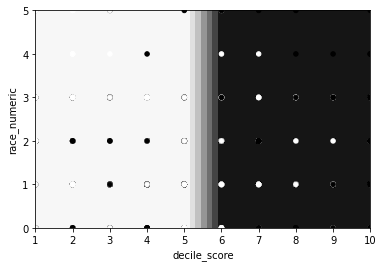

In [11]:
# Pair 2
df[["race_numeric"]] = df[["race"]]
df["race_numeric"].replace(df["race"].unique().tolist(),[0,1,2,3,4,5], inplace=True)

X_feature_2 = df[["decile_score", "race_numeric"]]
X_train_2, X_test_2, y_train_2, y_test_2 = model_selection.train_test_split(
    X_feature_2, y, test_size=0.25, random_state=42
)

logistic_race_model = linear_model.LogisticRegression(solver="lbfgs")
logistic_race_model.fit(X_train_2, y_train_2)

beta_0_2 = logistic_race_model.intercept_[0]
beta_1_2, beta_2_2 = logistic_race_model.coef_[0]

print(f"Fit model: p(recid) = L({beta_0_2:.4f} + {beta_1_2:.4f} decile_score + {beta_2_2:.4f} race)")

fit_and_plot_decision_boundary(
    linear_model.LogisticRegression(solver="lbfgs"),
    X_train_2, y_train_2, cmap=plt.cm.Greys
)

Fit model: p(recid) = L(-1.4109 + 0.2163 decile_score + 0.0763 priors_count)


/Users/clairefan/opt/anaconda3/envs/MLClass/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


<AxesSubplot:xlabel='decile_score', ylabel='priors_count'>

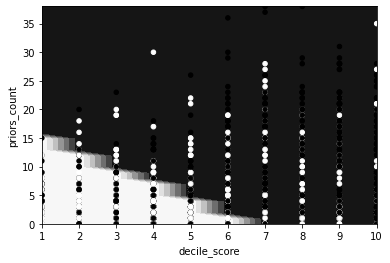

In [12]:
# Pair 3
X_feature_3 = df[["decile_score", "priors_count"]]
X_train_3, X_test_3, y_train_3, y_test_3 = model_selection.train_test_split(
    X_feature_3, y, test_size=0.25, random_state=42
)

logistic_priors_model = linear_model.LogisticRegression(solver="lbfgs")
logistic_priors_model.fit(X_train_3, y_train_3)

beta_0_3 = logistic_priors_model.intercept_[0]
beta_1_3, beta_2_3 = logistic_priors_model.coef_[0]

print(f"Fit model: p(recid) = L({beta_0_3:.4f} + {beta_1_3:.4f} decile_score + {beta_2_3:.4f} priors_count)")

fit_and_plot_decision_boundary(
    linear_model.LogisticRegression(solver="lbfgs"),
    X_train_3, y_train_3, cmap=plt.cm.Greys
)

Fit model: p(recid) = L(-1.3725 + 0.2601 decile_score + 0.2427 juv_fel_count)


/Users/clairefan/opt/anaconda3/envs/MLClass/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


<AxesSubplot:xlabel='decile_score', ylabel='juv_fel_count'>

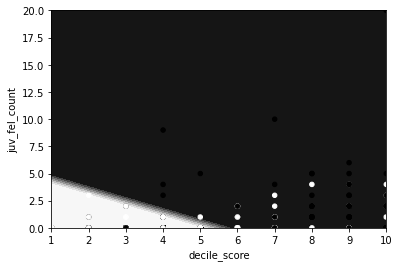

In [13]:
# Pair 4
X_feature_4 = df[["decile_score", "juv_fel_count"]]
X_train_4, X_test_4, y_train_4, y_test_4 = model_selection.train_test_split(
    X_feature_4, y, test_size=0.25, random_state=42
)

logistic_juv_model = linear_model.LogisticRegression(solver="lbfgs")
logistic_juv_model.fit(X_train_4, y_train_4)

beta_0_4 = logistic_juv_model.intercept_[0]
beta_1_4, beta_2_4 = logistic_juv_model.coef_[0]

print(f"Fit model: p(recid) = L({beta_0_4:.4f} + {beta_1_4:.4f} decile_score + {beta_2_4:.4f} juv_fel_count)")

fit_and_plot_decision_boundary(
    linear_model.LogisticRegression(solver="lbfgs"),
    X_train_4, y_train_4, cmap=plt.cm.Greys
)

### Answer
Pair 4 of 'decile_score' and 'juv_fel_count' shows the clearest decision boundaries.

## Model Evaluation

Before we get too far into additional classification algorithms, let’s take a
step back and think about how to evaluate the performance of a classification
model.

### Accuracy

Perhaps the most intuitive classification metric is *accuracy*, which is the
fraction of correct predictions.

For a scikit-learn classifier, this can be computed using the `score` method.

In [14]:
train_acc = logistic_age_model.score(X_train, y_train)
test_acc = logistic_age_model.score(X_test, y_test)

train_acc, test_acc

(0.6534195933456562, 0.667960088691796)

When the testing accuracy is similar to or higher than the training
accuracy (as it is here), the model might be underfitting.
Thus, we should consider either using a more powerful model or adding additional
features.

In many contexts, this would be an appropriate way to evaluate a model, but in
others, this is insufficient.

For example, suppose we want to use a classification model to predict the
likelihood of someone having a rare, but serious health condition.

If the condition is very rare (say it appears in 0.01% of the population), then
a model that always predicts false would have 99.99% accuracy, but the false
negatives could have large consequences.

### Precision and Recall

In order to capture situations like that, data scientists often use two other
very common metrics:

- *Precision*: The number of true positives over the number of positive
  predictions. Precision tells us how often the model was correct when it
  predicted true.  
- *Recall*: The number of true positives over the number of actual positives.
  Recall answers the question, “What fraction of the positives did we get
  correct?”  


In the rare health condition example, you may prefer
a model with high recall (never misses an at-risk patient), even if the
precision is a bit low (sometimes you have false positives).

On the other hand, if your algorithm filters spam emails out of an inbox,
you may prefer a model with high precision so that when an email is
classified as spam, it is very likely to actually be spam (i.e. non-spam
messages don’t get sent to spam folder).

In many settings, both precision and recall are equally important and a
compound metric known as the F1-score is used:

$$
F1 = 2 \frac{\text{precision} \cdot \text{recall}}{\text{precision} + \text{recall}}
$$

The F1 score is bounded between 0 and 1. It will only achieve a value of 1 if
both precision and recall are exactly 1.

We can have scikit-learn produce a textual report with precision and recall.

Scikit-learn

In [15]:
report = metrics.classification_report(
    y_train, logistic_age_model.predict(X_train),
    target_names=["no recid", "recid"]
)
print(report)

              precision    recall  f1-score   support

    no recid       0.67      0.73      0.69      2940
       recid       0.64      0.57      0.60      2470

    accuracy                           0.65      5410
   macro avg       0.65      0.65      0.65      5410
weighted avg       0.65      0.65      0.65      5410



### ROC and AUC

For classification algorithms, there is a tradeoff between precision and recall.

Let’s illustrate this point in the context of the logistic regression model.

The output of a logistic regression is a probability of an event or label.

To obtain a definite prediction from the algorithm, the modeler would
first select a threshold parameter $ p $ such that all model outputs above the
threshold are given the label of true.

As this $ p $ increases, the model must be relatively more confident before
assigning a label of true.

In this case, the model’s precision will increase (very confident when applying
true label), but the recall will suffer (will apply false to some true cases
that had a model output just below the raised threshold).

Machine learning practitioners have adapted a way to help us visualize
this tradeoff.

The visualization technique is known as the receiver operating characteristic
– or more commonly used ROC – curve 

> The name “receiver operating characteristic” comes from its origin;
> during World War II, engineers used ROC curves to measure how well a radar signal
> could be properly detected from noise (i.e. enemy aircraft vs. noise).

To understand this curve, consider two extremes choices for $ p $:

- When $ p=1 $, we will (almost surely) never predict any observation to
  have a label 1. In this case, the false positive rate will be equal to 0, as
  will the true positive rate.  
- When $ p=0 $, we will predict that all observations always have a label
  of 1. The false positive rate and true positive rates will be equal to 1.  


The *ROC curve* traces the relationship between the false positive rate (on
the x axis) and the true positive rate (on the y axis) as the probability
threshold $ p $ is changed.

Below, we define a function that uses scikit-learn to compute the true positive
rate and false positive rates. Then we plot these rates against
each other.

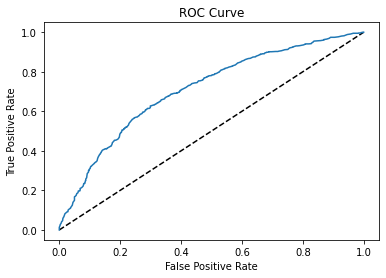

In [16]:
def plot_roc(mod, X, y):
    # predicted_probs is an N x 2 array, where N is number of observations
    # and 2 is number of classes
    predicted_probs = mod.predict_proba(X_test)

    # keep the second column, for label=1
    predicted_prob1 = predicted_probs[:, 1]

    fpr, tpr, _ = metrics.roc_curve(y_test, predicted_prob1)

    # Plot ROC curve
    fig, ax = plt.subplots()
    ax.plot([0, 1], [0, 1], "k--")
    ax.plot(fpr, tpr)
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("ROC Curve")

plot_roc(logistic_age_model, X_test, y_test)

We can use the ROC curve to determine the optimal threshold value.

Since the output of our recidivism application model could
potentially inform judicial decisions that impact the lives of individuals, we
should be careful when considering a threshold value with low false
positive rate vs high recall (low false negative rate).

We may choose to err on the side of low false negative rate so that when the model
predicts recidivism, recidivism will likely occur – in other words,
we would favor a high true positive rate even if the false positive rate is
higher.

### Exercise 3 (20 points)

Use the `metrics.roc_curve` function to determine an appropriate value
for the probability threshold, keeping in mind our preference for
high precision over high recall.

The third return value of `metrics.roc_curve` is an array of the
probability thresholds (`p`) used to compute each false positive rate and
true positive rate.

To do this problem, you may wish to do the following steps:

- Concoct objective function in terms of the `fpr` and `tpr`.  
- Evaluate the objective function using the `fpr` and `tpr` variables returned by the `metrics.roc_curve` function.  
- Use `np.argmin` to find the  *index* of the smallest value of the objective function.  
- Extract the value at the margin index from the probability threshold values array.  


If we cared about both precision and recall equally (we don’t here),
we might choose `(fpr - tpr)**2` as one objective function. With this
objective function, we would find the probability threshold value
that makes the false positive and true positive rates as equal as
possible.

In [17]:
# your answer here. Make more cells as needed
predicted_probs = logistic_age_model.predict_proba(X_test)

# keep the second column, for label=1
predicted_prob1 = predicted_probs[:, 1]
fpr, tpr, p_1 = metrics.roc_curve(y_test, predicted_prob1)

best_threshold_1 = p_1[np.argmin(fpr - tpr)]
print(f"The best threshold is {best_threshold_1:.4f}.")

The best threshold is 0.4724.


### Parameter Selection via ROC curve

The ROC curve can also be used to do hyper-parameter selection for the model’s
parameters.

To see how, consider a model with an ROC curve that has a single point at (0, 1)
– meaning the true positive rate is 1 and false positive rate is zero or
that the model has 100% accuracy.

Notice that integrating to obtain the area under the ROC curve returns
a value of 1 for the perfect model.

The area under any other ROC curve would be less than 1.

Thus, we could use the area under the curve (abbreviated AUC) as an objective
metric in cross-validation.

Let’s see an example.

In [18]:
predicted_prob1 = logistic_age_model.predict_proba(X)[:, 1]
auc = metrics.roc_auc_score(y, predicted_prob1)
print(f"Initial AUC value is {auc:.4f}")

# help(linear_model.LogisticRegression)

Initial AUC value is 0.7057


### Exercise 4 (20 points)

The `LogisticRegression` class with default arguments implements the
regression including `l2` regularization (it penalizes coefficient
vectors with an l2-norm).

The regularization strength is controlled by a parameter `C` that is
passed to the `LogisticRegression` constructor.

Smaller values of `C` lead to stronger regularization.

For example, `LogisticRegression(C=10)` would have weaker regularization
than `LogisticRegression(C=0.5)`.

Your task here is to use the `model_selection.cross_val_score` method to select an
optimal level for the regularization parameter `C`. The `scoring` argument should be set
to `roc_auc`.

Refer to the example in the [recidivism lecture](https://datascience.quantecon.org/recidivism.html) for how
to use `model_selection.cross_val_score`.

In [19]:
# your answer here. Make more cells as needed
highest_scores = []
C_range = [0.001, 0.01, 0.1, 0.5, 1, 5, 10, 100, 1000]
for i in C_range:
    lr_age_C = linear_model.LogisticRegression(C=i,solver="lbfgs",penalty="l2")
    scores = model_selection.cross_val_score(lr_age_C, X_train, y_train, scoring="roc_auc")
    avg_scores = scores.mean()
    highest_scores.append(avg_scores)
    print(f"For C = {i}, the score is {avg_scores}")
print(f"The best C is {C_range[highest_scores.index(max(highest_scores))]} and the score is {max(highest_scores)}")



For C = 0.001, the score is 0.703650265774326
For C = 0.01, the score is 0.7042362086535018
For C = 0.1, the score is 0.7042451596023025
For C = 0.5, the score is 0.7042451596023025
For C = 1, the score is 0.7042451596023025
For C = 5, the score is 0.7042451596023025
For C = 10, the score is 0.7042451596023025
For C = 100, the score is 0.7042451596023025
For C = 1000, the score is 0.7042451596023025
The best C is 0.1 and the score is 0.7042451596023025


### Comment:
The best regularization parameter C is 0.1.

In [20]:
LR = linear_model.LogisticRegression()
LRparam_grid = {'C': [0.001, 0.01, 0.1, 0.5, 1, 5, 10, 100, 1000]}
LR_search = model_selection.GridSearchCV(LR, param_grid=LRparam_grid, refit = True, verbose = 3, cv=5)

# fitting the model for grid search 
LR_search.fit(X_train , y_train)
LR_search.best_params_
# summarize
print('The best mean accuracy: %.3f' % LR_search.best_score_)
print('The best regularization parameter: %s' % LR_search.best_params_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END ...........................C=0.001;, score=0.667 total time=   0.0s
[CV 2/5] END ...........................C=0.001;, score=0.648 total time=   0.0s
[CV 3/5] END ...........................C=0.001;, score=0.665 total time=   0.0s
[CV 4/5] END ...........................C=0.001;, score=0.643 total time=   0.0s
[CV 5/5] END ...........................C=0.001;, score=0.646 total time=   0.0s
[CV 1/5] END ............................C=0.01;, score=0.672 total time=   0.0s
[CV 2/5] END ............................C=0.01;, score=0.648 total time=   0.0s
[CV 3/5] END ............................C=0.01;, score=0.666 total time=   0.0s
[CV 4/5] END ............................C=0.01;, score=0.641 total time=   0.0s
[CV 5/5] END ............................C=0.01;, score=0.641 total time=   0.0s
[CV 1/5] END .............................C=0.1;, score=0.672 total time=   0.0s
[CV 2/5] END .............................C=0.1;,

## Neural Network Classifiers

The final classifier we will visit today is a neural-network classifier, using
the multi-layer perceptron network architecture.

Recall from the [regression](https://datascience.quantecon.org/regression.html) chapter that a multi-layer
perceptron is comprised of a series of nested linear regressions separated by
non-linear activation functions.

The number of neurons (size of weight matrices and bias vectors) in each layer
were hyperparameters that could be chosen by modeler, but for regression, the last
layer had to have exactly one neuron which represented the single regression
target.

To use the MLP for classification tasks, we need to make three adjustments:

1. Construct a final layer with $ N $ neurons instead of 1, where $ N $ is the number of classes in the classification task.  
1. Apply a *softmax* function on the network output.  
1. Use the cross-entropy loss function instead of the MSE to optimize network weights and biases.  


The softmax function applied to a vector $ x \in \mathbb{R}^N $ is computed as

$$
\sigma(x)_i = \frac{e^{x_i}}{\sum_{j=1}^{N} e^{x_j}}
$$

In words, the softmax function is computed by exponentiating all the values,
then dividing by the sum of exponentiated values.

The output of the softmax function is a probability distribution (all
non-negative and sum to 1) weighted by the relative value of the input values.

Finally, the cross entropy loss function for $ M $ observations $ y $, with associated softmax vectors $ z $ is

$$
-\frac{1}{M} \sum_{j=1}^M \sum_{i=1}^N 1_{y_j = i} log\left(z_{i,j}\right)
$$

where $ 1_{y_j = i} $ is an indicator variable with the value of 1 if
the observed class was equal to $ i $ for the $ j $ th observation, 0
otherwise.

All the same tradeoffs we saw when we used the multi-layer perceptron for
regression will apply for classification tasks.

This includes positives like automated-feature enginnering and theoretically unlimited flexibility.

It also includes potential negatives, such as a risk of overfitting, high
computational expenses compared to many classification algorithms, and lack of
interpretability.

For a more detailed discussion, review the [regression lecture](https://datascience.quantecon.org/regression.html).

### Exercise 5 (25 points)

Use keras to build an MLP based classifier for the recidivism example we have been working with.

Hints:

- You should have only `Dense` layers in your network
- You should use the `sigmoid` activation on the output layer (so values will be between 0 and 1 and interpretable as a probability)
- You should be using the` BinaryCrossentropy` loss function
- The `BinaryAccuracy` metric is a good choice for a metric

Experiment with different inputs such as:

- The features to include  
- The number of layers and number of neurons in each layer  
- The l2 regularization parameter `alpha`  
- The solver  


See if you can create a model that outperforms logistic regression.

Keep in mind other things, like the degree of overfitting and time required
to estimate the model parameters. How do these compare to logistic
regression?

> Hint: use google to search for something like "binary classification keras" to get a jump start on your code

In [21]:
import tensorflow as tf

In [22]:
# Experiment 1
# Features:["decile_score", "age"]
# Number of layer: 2
model_0 = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation="relu",input_shape=(2,)), # the first layer
    tf.keras.layers.Dense(1, activation="sigmoid") # the output layer
])

model_0.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy()]
)

model_0.fit(
    X_train, y_train,
    epochs=10,
)

# Check the accuracy
train_acc_0 = model_0.evaluate(X_train, y_train)[1]
test_acc_0 = model_0.evaluate(X_test, y_test)[1]
print("Train accuracy:", train_acc_0)
print("Test accuracy:", test_acc_0)


2022-03-26 19:34:48.306148: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-26 19:34:48.347384: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/10
170/170 [==============================] - 0s 376us/step - loss: 2.3474 - binary_accuracy: 0.5449
Epoch 2/10
170/170 [==============================] - 0s 378us/step - loss: 0.6454 - binary_accuracy: 0.6361
Epoch 3/10
170/170 [==============================] - 0s 378us/step - loss: 0.6397 - binary_accuracy: 0.6300
Epoch 4/10
170/170 [==============================] - 0s 372us/step - loss: 0.6398 - binary_accuracy: 0.6376
Epoch 5/10
170/170 [==============================] - 0s 360us/step - loss: 0.6350 - binary_accuracy: 0.6453
Epoch 6/10
170/170 [==============================] - 0s 380us/step - loss: 0.6413 - binary_accuracy: 0.6372
Epoch 7/10
170/170 [==============================] - 0s 357us/step - loss: 0.6250 - binary_accuracy: 0.6541
Epoch 8/10
170/170 [==============================] - 0s 359us/step - loss: 0.6287 - binary_accuracy: 0.6484
Epoch 9/10
170/170 [==============================] - 0s 358us/step - loss: 0.6307 - binary_accuracy: 0.6494
Epoch 10/10
57/57 [

### Comment:
For model_0, the test accuracy is higher than the train accuracy. Thus, the model might be underfitting. We should try adding more layers.

In [23]:
# Experiment 2
# Features:["decile_score", "age"]
# Number of layer: 4
model_1 = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation="relu",input_shape=(2,)), # the first layer
    tf.keras.layers.Dense(60, activation="relu"), # the second layer
    tf.keras.layers.Dense(30, activation="relu"), # the third layer
    tf.keras.layers.Dense(1, activation="sigmoid") # the output layer
])

model_1.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy()]
)

model_1.fit(
    X_train, y_train,
    epochs=10,
)

# Check the accuracy
train_acc_1 = model_1.evaluate(X_train, y_train)[1]
test_acc_1 = model_1.evaluate(X_test, y_test)[1]
print("Train accuracy:", train_acc_1)
print("Test accuracy:", test_acc_1)

Epoch 1/10
170/170 [==============================] - 0s 541us/step - loss: 1.0145 - binary_accuracy: 0.5923
Epoch 2/10
170/170 [==============================] - 0s 524us/step - loss: 0.6314 - binary_accuracy: 0.6439
Epoch 3/10
170/170 [==============================] - 0s 505us/step - loss: 0.6347 - binary_accuracy: 0.6449
Epoch 4/10
170/170 [==============================] - 0s 495us/step - loss: 0.6385 - binary_accuracy: 0.6433
Epoch 5/10
170/170 [==============================] - 0s 499us/step - loss: 0.6279 - binary_accuracy: 0.6504
Epoch 6/10
170/170 [==============================] - 0s 491us/step - loss: 0.6287 - binary_accuracy: 0.6534
Epoch 7/10
170/170 [==============================] - 0s 483us/step - loss: 0.6288 - binary_accuracy: 0.6412
Epoch 8/10
170/170 [==============================] - 0s 492us/step - loss: 0.6331 - binary_accuracy: 0.6504
Epoch 9/10
170/170 [==============================] - 0s 501us/step - loss: 0.6268 - binary_accuracy: 0.6506
Epoch 10/10
57/57 [

### Comment:
The result is still not very good. Try to use other features.

In [24]:
# Experiment 3
# Features:["decile_score", "juv_fel_count"]
# Number of layer: 2
model_2 = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation="relu",input_shape=(2,)), # the first layer
    tf.keras.layers.Dense(60, activation="relu"), # the second layer
    tf.keras.layers.Dense(30, activation="relu"), # the third layer
    tf.keras.layers.Dense(1, activation="sigmoid") # the output layer
])

model_2.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy()]
)

model_2.fit(
    X_train_4, y_train_4,
    epochs=10,
)

# Check the accuracy
train_acc_2 = model_2.evaluate(X_train_4, y_train_4)[1]
test_acc_2 = model_2.evaluate(X_test_4, y_test_4)[1]
print("Train accuracy:", train_acc_2)
print("Test accuracy:", test_acc_2)

Epoch 1/10
170/170 [==============================] - 0s 527us/step - loss: 0.6697 - binary_accuracy: 0.5969
Epoch 2/10
170/170 [==============================] - 0s 492us/step - loss: 0.6299 - binary_accuracy: 0.6559
Epoch 3/10
170/170 [==============================] - 0s 485us/step - loss: 0.6325 - binary_accuracy: 0.6518
Epoch 4/10
170/170 [==============================] - 0s 487us/step - loss: 0.6275 - binary_accuracy: 0.6523
Epoch 5/10
170/170 [==============================] - 0s 487us/step - loss: 0.6243 - binary_accuracy: 0.6514
Epoch 6/10
170/170 [==============================] - 0s 486us/step - loss: 0.6268 - binary_accuracy: 0.6475
Epoch 7/10
170/170 [==============================] - 0s 489us/step - loss: 0.6218 - binary_accuracy: 0.6676
Epoch 8/10
170/170 [==============================] - 0s 487us/step - loss: 0.6255 - binary_accuracy: 0.6543
Epoch 9/10
170/170 [==============================] - 0s 491us/step - loss: 0.6271 - binary_accuracy: 0.6545
Epoch 10/10
57/57 [

### Comment：
It still doesn't improve a lot.

In [25]:
# Experiment 4
# Features:["decile_score", "juv_fel_count"]
# Number of layer: 2
# optimizer: SGD
model_3 = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation="relu",input_shape=(2,)), # the first layer
    tf.keras.layers.Dense(60, activation="relu"), # the second layer
    tf.keras.layers.Dense(30, activation="relu"), # the third layer
    tf.keras.layers.Dense(1, activation="sigmoid") # the output layer
])

model_3.compile(
    optimizer=tf.keras.optimizers.SGD(),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy()]
)

model_3.fit(
    X_train_4, y_train_4,
    epochs=10,
)

# Check the accuracy
train_acc_3 = model_3.evaluate(X_train_4, y_train_4)[1]
test_acc_3 = model_3.evaluate(X_test_4, y_test_4)[1]
print("Train accuracy:", train_acc_3)
print("Test accuracy:", test_acc_3)

Epoch 1/10
170/170 [==============================] - 0s 468us/step - loss: 0.6869 - binary_accuracy: 0.5614
Epoch 2/10
170/170 [==============================] - 0s 424us/step - loss: 0.6593 - binary_accuracy: 0.6318
Epoch 3/10
170/170 [==============================] - 0s 428us/step - loss: 0.6449 - binary_accuracy: 0.6499
Epoch 4/10
170/170 [==============================] - 0s 430us/step - loss: 0.6370 - binary_accuracy: 0.6557
Epoch 5/10
170/170 [==============================] - 0s 427us/step - loss: 0.6329 - binary_accuracy: 0.6528
Epoch 6/10
170/170 [==============================] - 0s 437us/step - loss: 0.6284 - binary_accuracy: 0.6549
Epoch 7/10
170/170 [==============================] - 0s 428us/step - loss: 0.6272 - binary_accuracy: 0.6521
Epoch 8/10
170/170 [==============================] - 0s 437us/step - loss: 0.6300 - binary_accuracy: 0.6547
Epoch 9/10
170/170 [==============================] - 0s 427us/step - loss: 0.6275 - binary_accuracy: 0.6524
Epoch 10/10
57/57 [

### Comment：
It still doesn't improve a lot and it doesn't outperform logistic regression. Considering the time required to estimate, it's better to use logistic regression model.

## Application: Predicting US Recessions

Let’s apply our new classification algorithm knowledge and use
[leading indicators](https://www.investopedia.com/terms/l/leadingindicator.asp)
to predict recessions in the US economy.

A leading indicator is a variable that moves or changes before the rest
of the economy.

Many different leading indicators have been proposed – we’ll use a few of them.

We won’t explicitly prove that these variables are actually leading indicators,
but will show a plot of each variables that lets us
visually inspect the hypothesis.

### Data Prep

Let’s first gather the data from FRED.

In [26]:
start = "1974-01-01"
end = datetime.date.today()

def pct_change_on_last_year(df):
    "compute pct_change on previous year, assuming quarterly"
    return (df - df.shift(4))/df.shift(4)

def get_indicators_from_fred(start=start, end=end):
    """
    Fetch quarterly data on 6 leading indicators from time period start:end
    """
    # yield curve, unemployment, change in inventory, new private housing permits
    yc_unemp_inv_permit = (
        web.DataReader(["T10Y2Y", "UNRATE", "CBIC1", "PERMIT"], "fred", start, end)
        .resample("QS")
        .mean()
    )

    # percent change in housing prices and retail sales
    hpi_retail = (
        web.DataReader(["USSTHPI", "SLRTTO01USQ661S"], "fred", start, end)
        .resample("QS")  # already quarterly, adjusting so index is same
        .mean()
        .pipe(pct_change_on_last_year)
        .dropna()
    )

    indicators = (
        yc_unemp_inv_permit
        .join(hpi_retail)
        .dropna()
        .rename(columns=dict(
            USSTHPI="pct_change_hpi",
            T10Y2Y="yield_curve",
            UNRATE="unemp",
            CBIC1="inventory",
            SLRTTO01USQ661S="retail_sales",
            PERMIT="house_permits"
        ))
    )

    return indicators

indicators = get_indicators_from_fred()

indicators.head()

,yield_curve,unemp,inventory,house_permits,pct_change_hpi,retail_sales
DATE,,,,,,
1976-04-01,0.801364,7.566667,61.087,1171.333333,0.073655,0.056936
1976-07-01,1.099687,7.733333,55.190,1345.000000,0.087653,0.037207
1976-10-01,1.467377,7.766667,20.163,1489.000000,0.080495,0.047523
1977-01-01,1.332222,7.500000,34.343,1562.000000,0.104962,0.037939
1977-04-01,1.248254,7.133333,51.245,1693.333333,0.111077,0.032931


Now, we also need data on recessions.

In [27]:
def get_recession_data():
    recession = (
        web.DataReader(["USRECQ"], "fred", start, end)
        .rename(columns=dict(USRECQ="recession"))
        ["recession"]
    )

    # extract start and end date for each recession
    start_dates = recession.loc[recession.diff() > 0].index.tolist()
    if recession.iloc[0] > 0:
        start_dates = [recession.index[0]] + start_dates

    end_dates = recession.loc[recession.diff() < 0].index.tolist()

    if (len(start_dates) != len(end_dates)) and (len(start_dates) != len(end_dates) + 1):
        raise ValueError("Need to have same number of start/end dates!")

    return recession, start_dates, end_dates

recession, start_dates, end_dates = get_recession_data()

Now, let’s take a look at the data we have.

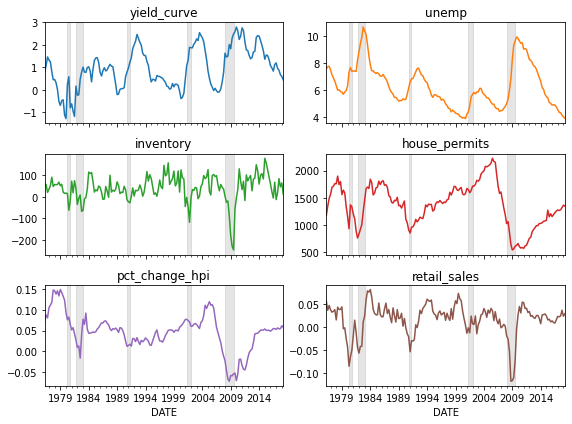

In [28]:
def add_recession_bands(ax):
    for s, e in zip(start_dates, end_dates):
        ax.axvspan(s, e, color="grey", alpha=0.2)

axs = indicators.plot(subplots=True, figsize=(8, 6), layout=(3, 2), legend=False)

for i, ax in enumerate(axs.flatten()):
    add_recession_bands(ax)
    ax.set_title(list(indicators)[i])

fig = axs[0, 0].get_figure()
fig.tight_layout();

For each of the chosen variables, you can see that the leading indicator
has a distinct move in periods leading up to a recession (noted by the grey bands in background).

### Exercise 6 (20 points)

Let’s pause here to take a few minutes and digest.

If the task is to use these leading indicators to predict a recession,
would high recall or high precision be more important for our model?

Would your answer change if you worked at the Federal Reserve?

What if you worked at a news company such as the Economist or the New York
Times?

### Answer:
Precision = TP / (TP + FP)

Recall = TP / (TP + FN)

I would prefer high recall over high precision. Because I am risk-averse and if there actually will be a recession, I would like to predict that and be fully prepared (I want high true positive and low false negative). And it doesn't matter if I predicted a recession but find out there actually isn't (I can accept a false positive). To conclude, low false negative is more important than low false positive to me. Thus high recall is more important to the model.

But if I work at the Federal Reserve, high precision will be more important. Because if there actually won't be a recession, I don't want the model to predict a recession making people panic (I want low false positive). I still want the model predict a recession if there actually will be one (I want high true positive). And I want the economic run smoothly and the model prediction doesn't make the recession worse (I can accept a false negative). To conclude, low false positive is more important than low false negative to me. Thus high precision is more important to the model.

If I work at news company, I want a balance of high precision and high recall. Because I want to report as truthful as possible (I want high true positive and high true negative). And I want either false positive or false negative to be low. Thus, the accuracy of the model is the most import to me.

### How Many leads?

If the variables we have chosen truly are leading indicators, we should be able
to use leading values of the variables to predict current or future recessions.

A natural question is: how many leads should we include?

Let’s explore that question by looking at many different sets of leads.

In [29]:
def make_train_data(indicators, rec, nlead=4):
    return indicators.join(rec.shift(nlead)).dropna()

def fit_for_nlead(ind, rec, nlead, mod):
    df = make_train_data(ind, rec, nlead)
    X = df.drop(["recession"], axis=1).copy()
    y = df["recession"].copy()

    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y)

    mod.fit(X_train, y_train)
    cmat = metrics.confusion_matrix(y_test, mod.predict(X_test))
    return cmat

mod = pipeline.make_pipeline(
    preprocessing.StandardScaler(),
    linear_model.LogisticRegression(solver="lbfgs")
)

cmats = dict()
for nlead in range(1, 11):
    cmats[nlead] = np.zeros((2, 2))
    print(f"starting for {nlead} leads")
    for rep in range(200):
        cmats[nlead] += fit_for_nlead(indicators, recession, nlead, mod)

    cmats[nlead] = cmats[nlead] / 200

for k, v in cmats.items():
    print(f"\n\nThe average confusion matrix for {k} lag(s) was:\n {v}")

starting for 1 leads
starting for 2 leads
starting for 3 leads
starting for 4 leads
starting for 5 leads
starting for 6 leads
starting for 7 leads
starting for 8 leads
starting for 9 leads
starting for 10 leads


The average confusion matrix for 1 lag(s) was:
 [[37.69  0.69]
 [ 1.47  3.15]]


The average confusion matrix for 2 lag(s) was:
 [[37.73  1.08]
 [ 2.71  2.77]]


The average confusion matrix for 3 lag(s) was:
 [[37.61   0.745]
 [ 2.715  1.93 ]]


The average confusion matrix for 4 lag(s) was:
 [[37.975  0.335]
 [ 2.67   2.02 ]]


The average confusion matrix for 5 lag(s) was:
 [[37.2    0.865]
 [ 3.615  1.32 ]]


The average confusion matrix for 6 lag(s) was:
 [[36.615  1.185]
 [ 3.875  1.325]]


The average confusion matrix for 7 lag(s) was:
 [[36.29  1.33]
 [ 3.67  1.71]]


The average confusion matrix for 8 lag(s) was:
 [[36.005  1.455]
 [ 3.655  1.885]]


The average confusion matrix for 9 lag(s) was:
 [[35.505  1.575]
 [ 4.345  1.575]]


The average confusion matrix for 1

From the averaged confusion matrices reported above, we see that the model with
only one leading period was the most accurate.

After that was the model with 4 leading quarters.

Depending on the application, we might favor a model with higher accuracy or
one that gives us more time to prepare (the 4 quarter model).

Why did the 1-lead and 4-lead models perform better than models with
another number of leads? Perhaps because different variables start moving a
different number of periods before the recession hits.

The exercise below asks you to explore this idea.

### Exercise 7 (20 points)

Extend the logic from the previous example and allow a different number
of leading periods for each variable.

How would you find the “optimal” number of leads for each variable? How
could you try to avoid overfitting?

Use `make_train_data_varying_leads` function below to construct your model.

In [30]:
def make_train_data_varying_leads(indicators, rec, nlead):
    """
    Apply per-indicator leads to each indicator and join with recession data

    Parameters
    ----------
    indicators: pd.DataFrame
        A DataFrame with timestamps on index and leading indicators as columns

    rec: pd.Series
        A Series indicating if the US economy was in a recession each period

    nlead: dict
        A dictionary which maps a column name to a positive integer
        specifying how many periods to shift each indicator. Any
        indicator not given a key in this dictionary will not be
        included in the output DataFrame.

    Returns
    -------
    df: pd.DataFrame
        A DataFrame with the leads applied and merged with the recession
        indicator

    Example
    -------

    ```
    df = make_train_data_varying_leads(
        indicators,
        recession,
        nlead=dict(yield_curve=3, unemp=4)
    )

    df.shape[1]  # == 3 (yield_curve, unemp, recession))
    ```

    """
    cols = []
    for col in list(indicators):
        if col in nlead:
            cols.append(indicators[col].shift(-nlead[col]))

    X = pd.concat(cols, axis=1)
    return X.join(rec).dropna()

In [31]:
# your answer here. Make more cells as needed
def fit_for_nlead_varying_leads(ind, rec, nlead, mod):
    df = make_train_data_varying_leads(ind, rec, nlead)
    X = df.drop(["recession"], axis=1).copy()
    y = df["recession"].copy()

    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y)

    mod.fit(X_train, y_train)
    cmat = metrics.confusion_matrix(y_test, mod.predict(X_test))
    return cmat

mod = pipeline.make_pipeline(
    preprocessing.StandardScaler(),
    linear_model.LogisticRegression(solver="lbfgs")
)

In [32]:
cmats_1 = dict()
cmats_1[0] = np.zeros((2,2))
nlead = dict(yield_curve=1, unemp=1, inventory=1, house_permits=1, pct_change_hpi=1, retail_sales=1)
for rep in range(200):
    cmats_1[0] += fit_for_nlead_varying_leads(indicators, recession, nlead, mod)
cmats_1[0] = cmats_1[0] / 200
accuracy_1 = (cmats_1[0][0][0] + cmats_1[0][1][1]) / (cmats_1[0][0][0] + cmats_1[0][0][1] + cmats_1[0][1][0] +cmats_1[0][1][1])
print(f"The confusion matrix is \n{cmats_1}")
print(f"Test Accuracy: {accuracy_1}")

The confusion matrix is 
{0: array([[36.76 ,  0.865],
       [ 1.68 ,  3.325]])}
Test Accuracy: 0.9403002580342481


In [33]:
cmats_2 = dict()
cmats_2[0] = np.zeros((2,2))
nlead = dict(yield_curve=4, unemp=4, inventory=1, house_permits=4, pct_change_hpi=4, retail_sales=4)
for rep in range(200):
    cmats_2[0] += fit_for_nlead_varying_leads(indicators, recession, nlead, mod)
cmats_2[0] = cmats_2[0] / 200
accuracy_2 = (cmats_2[0][0][0] + cmats_2[0][1][1]) / (cmats_2[0][0][0] + cmats_2[0][0][1] + cmats_2[0][1][0] +cmats_2[0][1][1])
print(f"The confusion matrix is \n{cmats_2}")
print(f"Test Accuracy: {accuracy_2}")

The confusion matrix is 
{0: array([[37.14 ,  0.39 ],
       [ 1.795,  2.675]])}
Test Accuracy: 0.9479761904761904


### Comment:
Because in previous example, 1-lead and 4-lead models perform better than models with other number of leads, so I tried to assign 1 or 4 leads to each indicator seperatelly and calculate the test accuracy. It turns out that for nlead = dict(yield_curve=1, unemp=1, inventory=1, house_permits=1, pct_change_hpi=1, retail_sales=1) and nlead = dict(yield_curve=4, unemp=4, inventory=1, house_permits=4, pct_change_hpi=4, retail_sales=4), the model returns the highest accuracy (though it may vary a little across each run). 

### Exercise 8 (20 points)

Experiment with different classifiers. Which ones perform better or worse?

How accurate can you become for each accuracy metric (accuracy, precision, and recall)?


Try at least three clasififiers

In [34]:
# your answer here. Make more cells as needed
# data preparation
Xy_recession = indicators.join(recession.shift(1)).dropna()
X_recession = Xy_recession.drop(["recession"],axis=1).copy()
y_recession = Xy_recession["recession"].copy()
X_recession_train, X_recession_test, y_recession_train, y_recession_test = model_selection.train_test_split(X_recession, y_recession, test_size=0.25, random_state=42)

In [35]:
# Experiment 1, MLP

model_recession_1 = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu",input_shape=(6,)), # the first layer
    tf.keras.layers.Dense(100, activation="relu"), # the second layer
    tf.keras.layers.Dense(100, activation="relu"), # the third layer
    tf.keras.layers.Dense(1, activation="sigmoid") # the output layer
])

model_recession_1.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=["BinaryAccuracy","Precision","Recall"]
)

model_recession_1.fit(
    X_recession_train, y_recession_train,
    epochs=10
)

prediction_1 = model_recession_1.predict(X_recession_test)

# Check the accuracy
train_acc_rec_1 = model_recession_1.evaluate(X_recession_train, y_recession_train)[1]
test_acc_rec_1 = model_recession_1.evaluate(X_recession_test, y_recession_test)[1]
print("Train accuracy:", train_acc_rec_1)
print("Test accuracy:", test_acc_rec_1)

Epoch 1/10
4/4 [==============================] - 0s 1ms/step - loss: 9.4389 - binary_accuracy: 0.7253 - precision: 0.3005 - recall: 0.4442    
Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 5.1147 - binary_accuracy: 0.9035 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 3/10
4/4 [==============================] - 0s 1ms/step - loss: 10.3475 - binary_accuracy: 0.9035 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 4/10
4/4 [==============================] - 0s 1ms/step - loss: 10.7675 - binary_accuracy: 0.8973 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 10.3515 - binary_accuracy: 0.8849 - precision: 0.8000 - recall: 0.1047    
Epoch 6/10
4/4 [==============================] - 0s 1ms/step - loss: 1.9058 - binary_accuracy: 0.8886 - precision: 0.5250 - recall: 0.2655    
Epoch 7/10
4/4 [==============================] - 0s 1ms/step - loss: 0.9654 - binary_accuracy: 0.8159 - precision: 0.382

In [36]:
# Experiment 2, Logistic regression

model_recession_2 = linear_model.LogisticRegression(solver="lbfgs")
model_recession_2.fit(X_recession_train, y_recession_train)

prediction_2 = model_recession_2.predict(X_recession_test)

train_acc_rec_2 = model_recession_2.score(X_recession_train, y_recession_train)
test_acc_rec_2 = model_recession_2.score(X_recession_test, y_recession_test)

print(f"Train accuracy: {train_acc_rec_2}")
print(f"Test accuracy: {test_acc_rec_2}")
print(f"Test precision: {metrics.precision_score(y_recession_test, prediction_2)}")
print(f"Test recall: {metrics.recall_score(y_recession_test, prediction_2)}")

Train accuracy: 0.9444444444444444
Test accuracy: 0.9534883720930233
Test precision: 1.0
Test recall: 0.6


/Users/clairefan/opt/anaconda3/envs/MLClass/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [37]:
# Experiment 3, Randomforest

from sklearn.ensemble import RandomForestClassifier

model_recession_3 = RandomForestClassifier(n_estimators = 100, max_depth=10, random_state=1111)
model_recession_3.fit(X_recession_train, y_recession_train)

prediction_3 = model_recession_3.predict(X_recession_test)

train_acc_rec_3 = model_recession_3.score(X_recession_train, y_recession_train)
test_acc_rec_3 = model_recession_3.score(X_recession_test, y_recession_test)

print(f"Train accuracy: {train_acc_rec_3}")
print(f"Test accuracy: {test_acc_rec_3}")
print(f"Test precision: {metrics.precision_score(y_recession_test, prediction_3)}")
print(f"Test recall: {metrics.recall_score(y_recession_test, prediction_3)}")


Train accuracy: 1.0
Test accuracy: 0.9534883720930233
Test precision: 1.0
Test recall: 0.6


### Comment:
For the MLP model in experiment 1, the train accuracy and teh test accuracy is not bad.

For the logistic model in experiment 2, the test accuracy is higher than the train accuracy, which means it might be underfitting.

For the random forest model in experiment 3, the train accuracy is 1.0, which means it might be overfitting.

Thus I think the pipeline of standard scaler and logistic regression in Exercise 7 and the MLP model are good choice.